In [1]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
import matplotlib
import json, math
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

In [2]:
########## PARAMS ##########
num_runs = 5
diss_rate_target = 0.99
aoi_target = 0.01
v = 43
frame_count = 5

density_low = 4.59598735
density_high = 11.95521146

#q_list = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]
q_list= [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220]
#p_list = [100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45]
p_list = [100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40]
i_list = [60, 120, 180, 240, 300, 360, 420, 480, 540]
#i_list = [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840]

nn = np.arange(100, 800, 25)

########## UTIL FUNCTIONS ##########

def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

def calculate_confidence_interval(data, confidence=.99):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

def cis_overlap(l_1, h_1, l_2, h_2):
    return (l_1 >= l_2 and l_1 <= h_2) or (h_1 >= l_2 and h_1 <= h_2)

def is_successful_config(diss_rate, excess_probability, config):
    return diss_rate[config] >= diss_rate_target and excess_probability[config] <= aoi_target


def get_best_config(diss_rate, excess_probability, diss_rate_ci):
    meets_reliability_target = len(diss_rate[diss_rate >= diss_rate_target]) > 0
    if meets_reliability_target:
        candidates = diss_rate >= diss_rate_target
        candidates = (1 - excess_probability) * candidates
        return np.unravel_index(np.argmax(candidates), candidates.shape)
    else:
        candidates = excess_probability <= aoi_target
        candidates = diss_rate * candidates
        best = np.unravel_index(np.argmax(candidates), candidates.shape)
        return best

def get_rdf_config_performance(n,i,q):
    diss_rate = []
    excess_probability = []

    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        return (0, 1, 0 ,0)

    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci)


def get_sf_config_performance(n,i,p):
    diss_rate = []
    excess_probability = []
    
    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v43_parsed/summary_kpi_sf_n{n}_i{i}_p{p}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        print('ERROR')
        return (0, 1, 0, 0)
        
    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci)

def get_pf_config_performance(n,i):
    p = 100
    diss_rate = []
    excess_probability = []
    
    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v43_parsed/summary_kpi_sf_n{n}_i{i}_p{p}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        print('ERROR')
        return (0, 1, 0, 0)
        
    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci)

def get_cbf_config_performance(n,i):
    vcbf = 43
    q = 0
    diss_rate = []
    excess_probability = []
    
    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{vcbf}_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        print('ERROR')
        return (0, 1, 0, 0)
        
    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci)

In [3]:
def get_rdf_performance(num_nodes):
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))
    reliability_target_ci = np.zeros((len(q_list), len(i_list)))
    delay_target_ci = np.zeros((len(q_list), len(i_list)))

    for x, q in enumerate(q_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci) = get_rdf_config_performance(num_nodes, i, q)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability
            reliability_target_ci[x][y] = diss_rate_ci
            delay_target_ci[x][y] = excess_probability_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci)

def get_sf_performance(num_nodes):
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))
    reliability_target_ci = np.zeros((len(q_list), len(i_list)))
    delay_target_ci = np.zeros((len(q_list), len(i_list)))

    for x, p in enumerate(p_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci) = get_sf_config_performance(num_nodes, i, p)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability
            reliability_target_ci[x][y] = diss_rate_ci
            delay_target_ci[x][y] = excess_probability_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci)

def get_pf_performance(num_nodes):
    reliability_target = np.zeros((1, len(i_list)))
    delay_target = np.zeros((1, len(i_list)))
    reliability_target_ci = np.zeros((1, len(i_list)))
    delay_target_ci = np.zeros((1, len(i_list)))

    for y, i in enumerate(i_list):
        (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci) = get_pf_config_performance(num_nodes, i)
        reliability_target[0][y] = diss_rate
        delay_target[0][y] = excess_probability
        reliability_target_ci[0][y] = diss_rate_ci
        delay_target_ci[0][y] = excess_probability_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci)

def get_cbf_performance(num_nodes):
    reliability_target = np.zeros((1, len(i_list)))
    delay_target = np.zeros((1, len(i_list)))
    reliability_target_ci = np.zeros((1, len(i_list)))
    delay_target_ci = np.zeros((1, len(i_list)))


    for y, i in enumerate(i_list):
        (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci) = get_cbf_config_performance(num_nodes, i)
        reliability_target[0][y] = diss_rate
        delay_target[0][y] = excess_probability
        reliability_target_ci[0][y] = diss_rate_ci
        delay_target_ci[0][y] = excess_probability_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci)

In [4]:
def get_metrics(get_performance_fkt, get_best_fkt=get_best_config):
    ep = []
    dr = []
    ep_ci = []
    dr_ci = []
    trajectory = []

    for n in nn:
        (reliability_target, delay_target, reliability_target_ci, delay_target_ci) = get_performance_fkt(n)
        best = get_best_fkt(reliability_target, delay_target, reliability_target_ci)
        if len(trajectory) >= 1:
            last_config = trajectory[-1]
            rtl = reliability_target[last_config]
            rtl_ci = reliability_target_ci[last_config]
            rtb = reliability_target[best]
            rtb_ci = reliability_target_ci[best]
            dtl = delay_target[last_config]
            dtl_ci = delay_target_ci[last_config]
            dtb = delay_target[best]
            dtb_ci = delay_target_ci[best]

            rtl_met = rtl >= diss_rate_target
            rtb_met = rtb >= diss_rate_target
            dtl_met = dtl <= aoi_target
            dtb_met = dtb <= aoi_target
            l_met = rtl_met and dtl_met
            b_met = dtb_met and rtb_met
            
            # # Both CIs overlap, we can use the old one
            # if (b_met == l_met) and cis_overlap(rtl-rtl_ci, rtl+rtl_ci, rtb-rtb_ci, rtb+rtb_ci) and cis_overlap(dtl-dtl_ci, dtl+dtl_ci, dtb-dtb_ci, dtb+dtb_ci):
            #     print('CHANGE', best, last_config)
            #     best = last_config

            # # The Diss rate CI overlaps, and the old one is actually better
            # if (b_met == l_met) and cis_overlap(rtl-rtl_ci, rtl+rtl_ci, rtb-rtb_ci, rtb+rtb_ci) and dtl <= dtb:
            #     print('CHANGE', best, last_config)
            #     best = last_config

            # # No targets met but diss rates overlap
            # if (not rtl_met) and (not rtb_met) and cis_overlap(rtl-rtl_ci, rtl+rtl_ci, rtb-rtb_ci, rtb+rtb_ci):
            #     print('CHANGE', best, last_config)
            #     best = last_config

            # if (not dtl_met) and (not dtb_met) and rtl_met and rtb_met and cis_overlap(dtl-dtl_ci, dtl+dtl_ci, dtb-dtb_ci, dtb+dtb_ci):
            #     print('CHANGE', best, last_config)
            #     best = last_config

        trajectory.append(best)
        ep.append(delay_target[best] * 100)
        dr.append(reliability_target[best] * 100)
        ep_ci.append(delay_target_ci[best] * 100)
        dr_ci.append(reliability_target_ci[best] * 100)

    ep = np.array(ep)
    dr = np.array(dr)
    ep_ci = np.array(ep_ci)
    dr_ci = np.array(dr_ci)
    return (ep, dr, ep_ci, dr_ci, trajectory)


(sf_ep, sf_dr, sf_ep_ci, sf_dr_ci, sf_trajectory) = get_metrics(get_sf_performance)
(rdf_ep, rdf_dr, rdf_ep_ci, rdf_dr_ci, rdf_trajectory) = get_metrics(get_rdf_performance)
(pf_ep, pf_dr, pf_ep_ci, pf_dr_ci, _) = get_metrics(get_pf_performance)
(cbf_ep, cbf_dr, cbf_ep_ci, cbf_dr_ci, _) = get_metrics(get_cbf_performance)

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERRO

/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


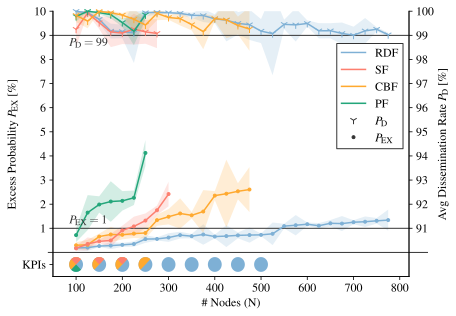

In [5]:
## Plot KPI comparison
ep_max = 10
width = 30

rdf_color = '#7eb0d5'
sf_color = '#fd7f6f'
pf_color = '#23a67a'
cbf_color = '#ffa92f'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x_max =800

ax1.plot([40, x_max +60], [0,0], color='#333', lw=1, clip_on=False)
ax1.plot([50, x_max +20], [1,1], color='#333', lw=1)
ax1.text(85, 1.1, '$P_\mathrm{EX} = 1$', ha="left", va="bottom", color="#333", fontsize=12)

ax2.plot([50, x_max +20], [99, 99], color='#333', lw=1)
ax2.text(85, 98.9, '$P_\mathrm{D} = 99$', ha="left", va="top", color="#333", fontsize=12)

connected_at =1.44 * (6 / 0.509)**2

# ax1.fill_between([density_low*36, connected_at], [-1,-1], [ep_max * 1.07, ep_max * 1.07], facecolor='#ebebeb', interpolate=True, clip_on=False, hatch='\\\\', ec='#fff', lw=0)
# ax1.fill_between([connected_at, density_high* 36], [-1,-1], [ep_max * 1.07, ep_max * 1.07], facecolor='#ebebeb', interpolate=True, clip_on=False)
# ax1.text(density_high * 36, ep_max * 1.12, "DOOLE REGION",  ha="right", va="top", color='#333', fontsize=10)
# ax1.plot([connected_at, connected_at],[-1, ep_max * 1.07], color='#333', clip_on=False, lw=1)
# ax1.text(connected_at + 40, ep_max * 0.65, "Percolation\nThreshold",  ha="left", va="center", color='#333')
# arrow = patches.FancyArrowPatch((connected_at + 38, ep_max * 0.65), (connected_at + 2, ep_max * 0.70), connectionstyle=f"arc3,rad=-0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
# ax1.add_patch(arrow)

ax1.set_xlabel('\# Nodes (N)')
ax1.set_ylabel('Excess Probability $P_\mathrm{EX}$ [\%]')
cbf_max = 16
sf_max = 9
pf_max = 7

## RDF
ax1.plot(nn, rdf_ep, '.-', color=rdf_color)
ax1.fill_between(nn, rdf_ep-rdf_ep_ci, rdf_ep+rdf_ep_ci, facecolor=rdf_color, interpolate=True, alpha=0.2)

## CBF
ax1.plot(nn[0:cbf_max], cbf_ep[0:cbf_max], '.-', color=cbf_color)
ax1.fill_between(nn[0:cbf_max], cbf_ep[0:cbf_max] - cbf_ep_ci[0:cbf_max], cbf_ep[0:cbf_max] + cbf_ep_ci[0:cbf_max], facecolor=cbf_color, interpolate=True, alpha=0.2)

## SF
ax1.plot(nn[0:sf_max], sf_ep[0:sf_max], '.-', color=sf_color)
ax1.fill_between(nn[0:sf_max], sf_ep[0:sf_max] - sf_ep_ci[0:sf_max], sf_ep[0:sf_max] + sf_ep_ci[0:sf_max], facecolor=sf_color, interpolate=True, alpha=0.2)

## PF
ax1.plot(nn[0:pf_max], pf_ep[0:pf_max], '.-', color=pf_color)
ax1.fill_between(nn[0:pf_max], pf_ep[0:pf_max] - pf_ep_ci[0:pf_max], pf_ep[0:pf_max] + pf_ep_ci[0:pf_max], facecolor=pf_color, interpolate=True, alpha=0.2)

ax1.tick_params(axis='y')
ax1.set_ylim(-1, ep_max * 1.0)
ax1.set_xlim(80, x_max)
ax1.set_yticks([-0.5] + list(np.arange(1, ep_max + 1, 1)))
ax1.set_yticklabels(['KPIs'] + list(range(1, ep_max + 1)))

ax2.set_ylabel('Avg Dissemination Rate $P_\mathrm{D}$ [\%]')

ax2.plot(nn, rdf_dr, '1-', ms=8, color=rdf_color, clip_on=False)
ax2.fill_between(nn, rdf_dr - rdf_dr_ci, rdf_dr + rdf_dr_ci, facecolor=rdf_color, interpolate=True, alpha=0.2)

ax2.plot(nn[0:8], sf_dr[0:8], '1-', ms=8, color=sf_color, clip_on=False)
ax2.fill_between(nn[0:8], sf_dr[0:8] - sf_dr_ci[0:8], sf_dr[0:8] + sf_dr_ci[0:8], facecolor=sf_color, interpolate=True, alpha=0.2)

ax2.plot(nn[0:7], pf_dr[0:7], '1-', ms=8, color=pf_color, clip_on=False)
ax2.fill_between(nn[0:7], pf_dr[0:7] - pf_dr_ci[0:7], pf_dr[0:7] + pf_dr_ci[0:7], facecolor=pf_color, interpolate=True, alpha=0.2)

ax2.plot(nn[0:cbf_max], cbf_dr[0:cbf_max], '1-', ms=8, color=cbf_color, clip_on=False)
ax2.fill_between(nn[0:cbf_max], cbf_dr[0:cbf_max] - cbf_dr_ci[0:cbf_max], cbf_dr[0:cbf_max] + cbf_dr_ci[0:cbf_max], facecolor=cbf_color, interpolate=True, alpha=0.2)


ax1aspect = get_aspect(ax1)
scale = 5
for i in range(len(nn)):
    n = nn[i]

    if n % 50 != 0:
        continue
    check_x = [n-2.3, n-0.6, n+3]
    check_y = (np.array([-12.39882697947214, -14.382639296187682, -9.919061583577713]) / ax1aspect) -0.085

    rdf_ep_target_met = rdf_ep[i] <= aoi_target * 100
    rdf_dr_target_met = rdf_dr[i] >= diss_rate_target * 100
    sf_ep_target_met = sf_ep[i] <= aoi_target * 100
    sf_dr_target_met = sf_dr[i] >= diss_rate_target * 100
    cbf_ep_target_met = cbf_ep[i] <= aoi_target * 100
    cbf_dr_target_met = cbf_dr[i] >= diss_rate_target * 100
    pf_ep_target_met = pf_ep[i] <= aoi_target * 100
    pf_dr_target_met = pf_dr[i] >= diss_rate_target * 100

    if rdf_ep_target_met and rdf_dr_target_met:
        t1 = matplotlib.patches.Ellipse((n,-0.5), width=width, height=width / ax1aspect, fill=True, fc=rdf_color, lw=0, ec= '#fff', clip_on=False)
        ax1.add_patch(t1)

    if cbf_ep_target_met and cbf_dr_target_met:
        mask = plt.Polygon([[n + width/2, -0.5+width/(2*ax1aspect)],[n -width/2, -0.5-width/(2*ax1aspect)], [n-width/2, -0.5+width/(2*ax1aspect)]], fill=False, lw=0)
        ax1.add_patch(mask)
        t1 = matplotlib.patches.Ellipse((n,-0.5), width=width, height=width / ax1aspect, fill=True, fc=cbf_color, lw=0, clip_path=mask)
        ax1.add_patch(t1)

    if sf_ep_target_met and sf_dr_target_met:
        mask = plt.Polygon([[n + width/2, -0.5+width/(2*ax1aspect)],[n,-0.5], [n-width/2, -0.5+width/(2*ax1aspect)]], fill=False, lw=0)
        ax1.add_patch(mask)
        t1 = matplotlib.patches.Ellipse((n,-0.5), width=width, height=width / ax1aspect, fill=True, fc=sf_color, lw=0, clip_path=mask if (rdf_dr_target_met and rdf_ep_target_met) else None)
        ax1.add_patch(t1)

    if pf_ep_target_met and pf_dr_target_met:
        mask = plt.Polygon([[n + width / 2, -0.5-width/(2*ax1aspect)],[n,-0.5], [n-width / 2, -0.5-width/(2*ax1aspect)]], fill=False, lw=0)
        ax1.add_patch(mask)
        t1 = matplotlib.patches.Ellipse((n,-0.5), width=width, height=width / ax1aspect, fill=True, fc=pf_color, lw=0, clip_path=mask if (rdf_dr_target_met and rdf_ep_target_met) else None)
        ax1.add_patch(t1)
        
    # if (rdf_ep_target_met and rdf_dr_target_met) or (sf_ep_target_met and sf_dr_target_met):
    #     ax1.plot(check_x, check_y, color='#fff', lw=1)

ax2.tick_params(axis='y')
ax2.set_ylim(89, 100)
ax2.set_xlim(50, x_max + 20)
ax2.set_yticks(np.arange(91, 101, 1))
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)

plt.plot([-1],[0], label='RDF', color=rdf_color)
plt.plot([-1],[0], label='SF', color=sf_color)
plt.plot([-1],[0], label='CBF', color=cbf_color)
plt.plot([-1],[0], label='PF', color=pf_color)
plt.plot([-1],[0], '1', ms=8, label='$P_\mathrm{D}$', color='#333')
plt.plot([-1],[0], '.',label='$P_\mathrm{EX}$', color='#333')
leg = plt.legend(fancybox=False, loc=7, bbox_to_anchor=(1, 0.68), framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

fig.savefig(f"../figures/best_config_performance_adv_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/best_config_performance_adv_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()